In [1]:
!pip install optuna

In [3]:
!pip install qiskit_machine_learning

     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     ----------------- --------------------- 61.4/133.4 kB 3.2 MB/s eta 0:00:01
     -------------------------- ------------ 92.2/133.4 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 133.4/133.4 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   -----------------------------

### Importing Libraries

in the code bellow the required liberaries for our task are imported. 

In [2]:
import optuna
from sklearn import model_selection
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.svm import *
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.decomposition import *
from sklearn.preprocessing import MinMaxScaler

from qiskit import *
from qiskit.circuit.library import *
from qiskit.utils import *
from qiskit_machine_learning.algorithms import *
from qiskit_machine_learning.kernels import *
from qiskit_machine_learning.datasets import *
import warnings
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap

from qiskit_machine_learning.datasets import ad_hoc_data

warnings.filterwarnings("ignore")
from qiskit_algorithms.utils import algorithm_globals

seed = 12345
np.random.seed(seed)
algorithm_globals.random_seed = seed


c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Generation

To generate dummy data for this tutorial, you can utilize the `ad_hoc_data` function from `qiskit_machine_learning.datasets`. This function allows you to specify the size of the training and test samples, along with the number of features (`n`) for each instance in the sample. An important parameter to consider is `gap`, which defines how close the classes are from each other. The smaller the gap, the harder it will be to classify the samples.

#### Function: generate_adhoc_data

#### Description:
This function generates ad hoc dummy data using the `ad_hoc_data` function from `qiskit_machine_learning.datasets`. It provides flexibility in controlling the size of the dataset, the number of features per instance, and the gap between classes.

#### Parameters:
- **training_size** (*int*): Size of the training sample.
- **test_size** (*int*): Size of the test sample.
- **n_features** (*int*): Number of features for each instance in the sample.
- **gap** (*float*): Defines how close the classes are from each other. The smaller the gap, the harder it will be to classify the samples.
- **plot_data** (*bool*): Whether to plot the generated data. Default is False.
- **one_hot** (*bool*): Whether to use one-hot encoding for the labels. Default is False.
- **include_sample_total** (*bool*): Whether to include the total number of samples in the return values. Default is True.

#### Returns:
- **train_features** (*numpy.ndarray*): Feature matrix of the training set.
- **train_labels** (*numpy.ndarray*): Labels of the training set.
- **test_features** (*numpy.ndarray*): Feature matrix of the test set.
- **test_labels** (*numpy.ndarray*): Labels of the test set.
- **adhoc_total** (*int*): Total number of samples if include_sample_total is True, otherwise None.


In [3]:
def generate_adhoc_data(training_size, test_size, n_features, gap, plot_data=False, one_hot=False, include_sample_total=True):
    """
    Generate dummy data using the ad_hoc_data function from qiskit_machine_learning.datasets.

    Parameters:
    - training_size (int): Size of the training sample.
    - test_size (int): Size of the test sample.
    - n_features (int): Number of features for each instance in the sample.
    - gap (float): Defines how close the classes are from each other. 
                   The smaller the gap, the harder it will be to classify the samples.
    - plot_data (bool): Whether to plot the generated data. Default is False.
    - one_hot (bool): Whether to use one-hot encoding for the labels. Default is False.
    - include_sample_total (bool): Whether to include the total number of samples in the return values. Default is True.
    
    Returns:
    - train_features (numpy.ndarray): Feature matrix of the training set (training_size,n_features).
    - train_labels (numpy.ndarray): Labels of the training set(training_size,).
    - test_features (numpy.ndarray): Feature matrix of the test set (test_size,n_features).
    - test_labels (numpy.ndarray): Labels of the test set (test_size,).
    - adhoc_total (int): Total number of samples if include_sample_total is True, otherwise None.
    """
    train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
        training_size=training_size,
        test_size=test_size,
        n=n_features,
        gap=gap,
        plot_data=plot_data,
        one_hot=one_hot,
        include_sample_total=include_sample_total
    )
    return train_features, train_labels, test_features, test_labels, adhoc_total




In [4]:
# Example usage:
train_features, train_labels, test_features, test_labels, adhoc_total = generate_adhoc_data(
    training_size=50,
    test_size=20,
    n_features=3,
    gap=0.25,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)

In [5]:
train_features.shape

(100, 3)

In [6]:
train_labels.shape

(100,)

In [7]:
test_features.shape

(40, 3)

In [8]:
test_labels.shape

(40,)

### Kernel Methods for Machine Learning

Kernel techniques are algorithms for pattern analysis that use kernel functions to operate in high-dimensional feature spaces. They are widely used in Support Vector Machines (SVMs), which are especially beneficial for classification jobs. SVMs seek to identify decision boundaries in high-dimensional spaces, and kernels aid in this process, particularly when the data is not linearly separated.

The "kernel trick" transforms nonlinearly separable data distributions into linearly separable problems by implicitly transferring input data into higher-dimensional spaces. This idea applies beyond SVMs to unsupervised methods such as Spectral Clustering, in which data points are represented as nodes in a graph and grouped via graph partitioning.

### Kernel Functions

Mathematically, kernel functions follow:

$k(x, y) = \phi(x) \cdot \phi(y)$

Where:
- $k$ is the kernel function
- $x, y$ are $n$-dimensional inputs
- $\phi$ maps from $n$-dimensional to $m$-dimensional space
- $\cdot$ denotes the inner product

Matrix representation of the kernel function for finite data:

$$
K = \begin{bmatrix}
k(x_1, x_1) & \cdots & k(x_1, x_n) \\
\vdots & \ddots & \vdots \\
k(x_n, x_1) & \cdots & k(x_n, x_n)
\end{bmatrix}
$$

### Quantum Kernels

Quantum feature maps are used in quantum kernel machine learning to carry out the kernel trick. Quantum feature maps are used to translate classical feature vectors to Hilbert spaces and generate quantum kernels.Mathematically:

$K_{ij} = |\langle \Phi(x_i) | \Phi(x_j) \rangle|^2$

Where:
- $K$ is the kernel matrix
- $x_i, x_j$ are $n$-dimensional inputs
- $\Phi$ is the quantum feature map
- $\langle \cdot | \cdot \rangle$ denotes the inner product of two quantum states

Quantum kernels can be used in novel quantum kernel techniques like the QSVC class offered by qiskit-machine-learning, as well as existing techniques like Pegasos QSVC and Quantum Kernel Training. Quantum kernels can also be employed in classical kernel learning algorithms like SVMs or clustering algorithms.

Additionally, it's worth mentioning that this equation represents the fidelity, and in quantum circuits we use different techniques to mesaure them such as the swap test and the computeUncompute method which will be described a in later section. The next section illustrates the feature map used in this notebook.


## ZZFeatureMap Circuit

### Description

The `ZZFeatureMap` circuit is a second-order Pauli-Z evolution circuit used in quantum machine learning tasks. It is implemented in Qiskit as part of the circuit library and it is used as the feature map for constructing our quantum circuit.

A ZZFeatureMap for a sample of 3 features is shown in the figure bellow:

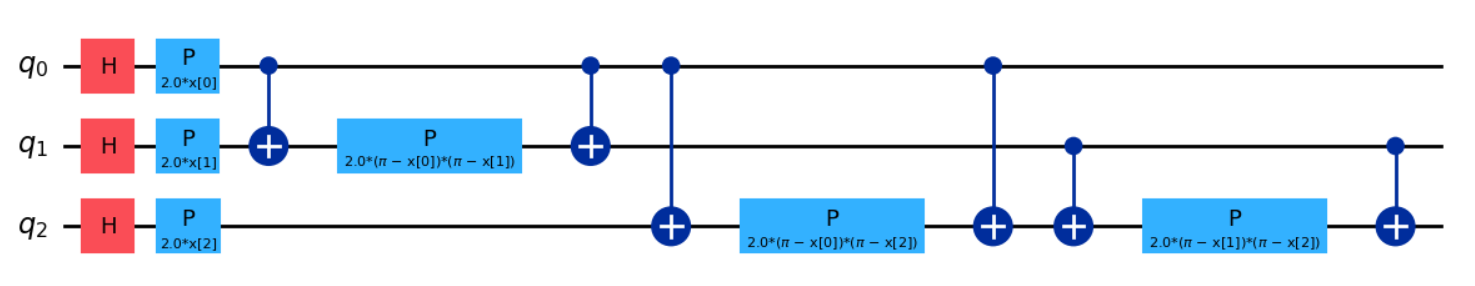

The python syntax for the function is provided below:
```python
ZZFeatureMap(feature_dimension, reps=2, entanglement='full', data_map_func=None, parameter_prefix='x', insert_barriers=False, name='ZZFeatureMap')


where : 
- **feature_dimension** (int): Number of features of the samples.
- **reps** (int): The number of repeated circuits, with a minimum value of 1.
- **entanglement** (str or list or callable): Specifies the entanglement method.
- **data_map_func** (callable): A mapping function for data x.
- **parameter_prefix** (str): The prefix used if default parameters are generated.
- **insert_barriers** (bool): If True, barriers are inserted in between the evolution instructions and Hadamard layers.
- **name** (str): The name of the ZZFeatureMap circuit.

The example code bellow demonstrates using the ZZFeatureMap function and plots the detailed block diagram for a 5 feature sample

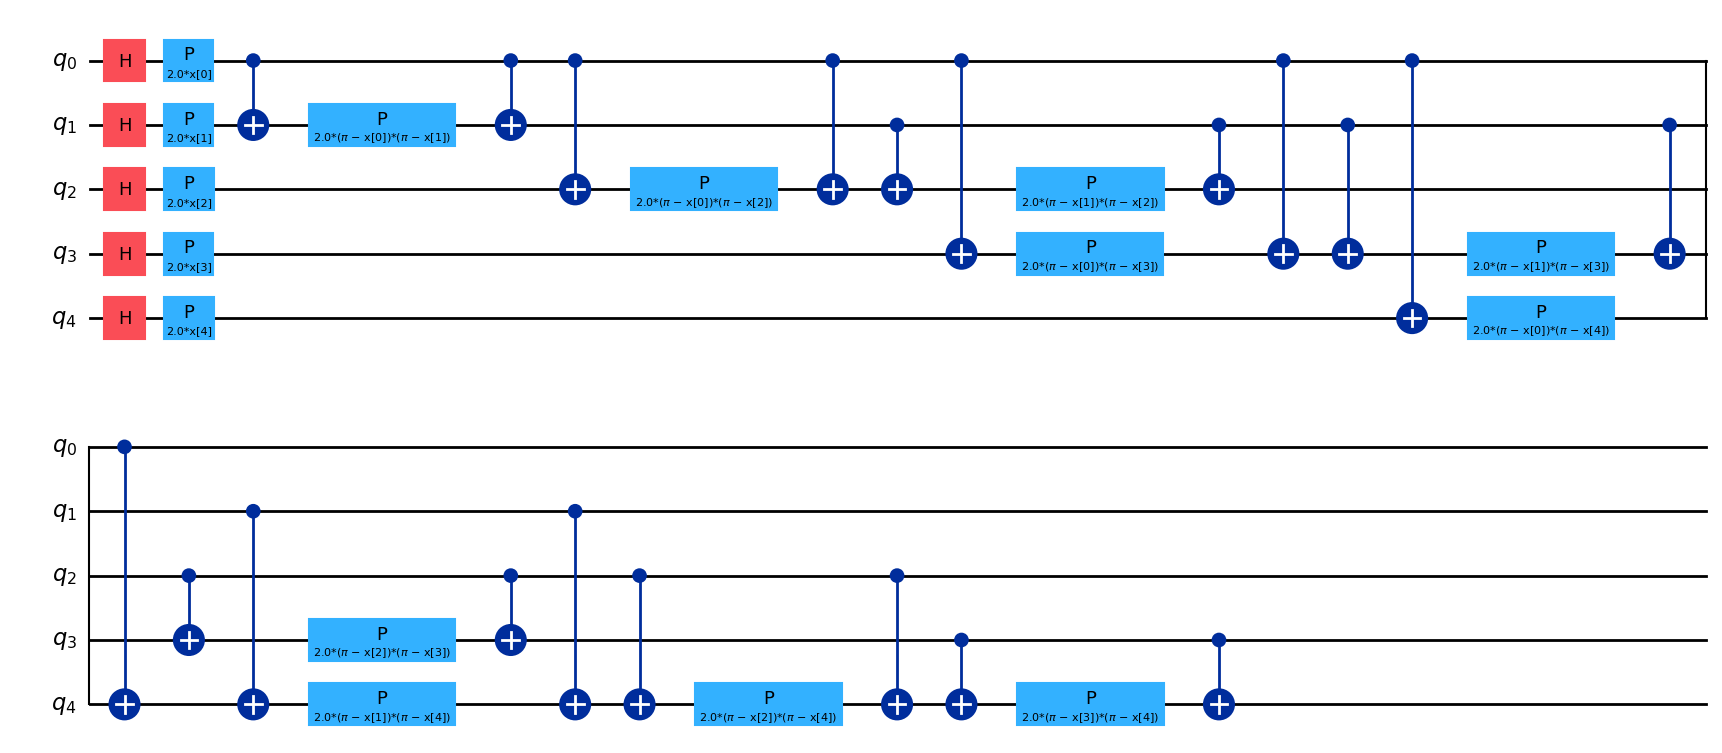

In [17]:

# Create a ZZFeatureMap circuit
zz_map = ZZFeatureMap(5, reps=1)

# Draw the circuit
zz_map.decompose().draw("mpl")

In the upcoming section, we delve into the application of the Compute-Uncompute technique, a method employed for computing the fidelity between two quantum states. 

## Compute-Uncompute Technique for Fidelity Calculation

In quantum computing, the "Compute-Uncompute" technique is a method used to calculate the fidelity between two quantum states. Fidelity is a measure of how similar two quantum states are, with a fidelity of 1 indicating that the states are identical.

The basic idea behind the Compute-Uncompute technique is to:

1. **State Preparation**: Start by preparing the initial quantum state, let's call it $ |\psi_0\rangle $.
2. **Compute**: Apply the quantum operations necessary to transform $ |\psi_0\rangle $ into the target state $ |\psi_{\text{target}}\rangle $. This involves applying a sequence of quantum gates or circuits.
3. **Uncompute**: After transforming the state, apply the reverse operations (also known as the "inverse circuit") to return to the original state $ |\psi_0\rangle $.
4. **Measurement**: Measure the final state after the uncompute step. The probability of obtaining the original state $ |\psi_0\rangle $ indicates the fidelity between $ |\psi_0\rangle $ and $ |\psi_{\text{target}}\rangle $.

the image bellow demonstrates the steps of compute-Uncompute for a 5 feature sample which the feature map applied with a repeatition of two: 
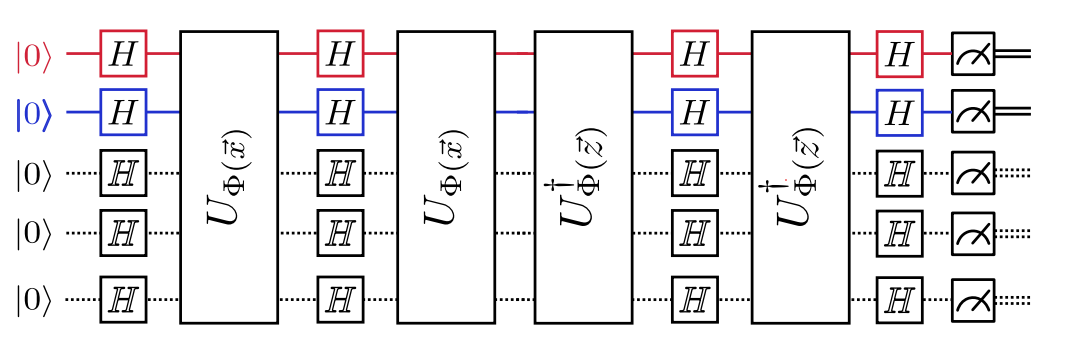

In practice, fidelity calculations using Compute-Uncompute often involves implementing the circuits on a quantum computer and running multiple experiments to collect statistics for fidelity estimation. In the following section we combine the mentioned information to build an Support Vector Classifier using zzFeaturemap circuit.




### Quantum SVC Model with Hyperparameter Optimization

In this section the information mentioned before is utilized to build an Support Vector Classifier (SVC) using a Quantum Kernel. Optuna Libarary is used to perform grid search to find the best parameters for the SVC model and the quantum kernel used.

The objective function bellow integrates several components to build and optimize a quantum-enhanced Support Vector Classifier (SVC) using Optuna for hyperparameter optimization.

#### Function Overview
The function combines the following steps:

1. **Sample Encoding**: Utilizes `zzFeaturemap` to encode samples.
2. **Fidelity Calculation**: Performs compute-uncompute to calculate fidelity between two states.
3. **Adhoc Kernel Construction**: Constructs an adhoc kernel using compute-uncompute for fidelity and zzFeaturemap for feature mapping.
4. **SVC Model Creation**: Utilizes the constructed kernel with a Support Vector Classifier (SVC).
5. **Accuracy Calculation**: Computes the accuracy of the SVC model using cross-validation.
6. **Hyperparameter Optimization**: Employs the Optuna library to optimize parameters for both the Quantum kernel and the SVC within the defined search space.

#### Grid Search Parameters
- **Number of Repetitions**: Determines the number of repetitions of the quantum circuit.
- **Regularization Parameter for SVC (C)**: Controls the regularization strength for the SVC.
- **Type of Entanglement**: Specifies the type of entanglement in the quantum feature map (e.g., "full" or "linear").
- **Number of Measurements**: Determines the number of measurements in the quantum circuit, influencing computation accuracy.


This comprehensive function streamlines the process of building and optimizing a quantum-enhanced SVC model, ensuring effective exploration of the hyperparameter space for optimal performance.


In [19]:
def objective(trial): 
    """
    Objective function for hyperparameter optimization of a quantum-enhanced Support Vector Classifier (SVC).

    Parameters:
    - trial (optuna.Trial): A single trial containing the current hyperparameters to evaluate.

    Returns:
    - float: Mean accuracy of the SVC model obtained through cross-validation.
    """
    # Grid search parameters
    rep = trial.suggest_int("rep", 1, 5)  # Number of repetitions for the quantum circuit
    c = trial.suggest_float("C", 0.1, 1000)  # Regularization parameter for SVC
    entangle = trial.suggest_categorical("entanglement", ["full", "linear"])  # Type of entanglement in the quantum feature map
    shots = trial.suggest_int("shots", 100, 10000)  # Number of measurements in the quantum circuit

    # Number of qubits used, equal to the number of features of each sample
    num_qubits = train_features.shape[1]
    
    # Quantum feature map encoding strategy
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=rep, entanglement=entangle)

    # Sampler for executing quantum circuits
    sampler = Sampler(options={"shots": shots})

    # Method for computing the fidelity between two quantum states
    fidelity = ComputeUncompute(sampler=sampler)

    # Creating a kernel object using the fidelity computation method and the encoding strategy
    adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

    # Evaluating the Gram matrix using the kernel object
    gram_train = adhoc_kernel.evaluate(x_vec=train_features, y_vec=train_features)

    # Creating an SVC classifier object
    classifier_obj = SVC(kernel="precomputed", shrinking=True, C=c, random_state=seed)

    # Applying cross-validation using the SVC model with the generated Gram matrix
    score = model_selection.cross_val_score(classifier_obj, gram_train, train_labels, n_jobs=10, cv=5)
    
    # Computing the mean accuracy obtained from cross-validation
    accuracy = score.mean()
    
    return accuracy



This code bellow initializes a hyperparameter optimization study named 'QSVM' using Optuna, setting the direction of optimization to maximize the objective function which is the accuracy of the SVC as it the return of the function. Employing the TPE sampler internally, it efficiently explores the hyperparameter space to identify promising regions. The optimization process is initiated with a timeout of 10*60 which is equal to 10 minutes after which the process will return the best parameters found.

In [20]:
study = optuna.create_study(direction="maximize",study_name='QSVM') # internally it uses the TPE samplerhttps://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html
study.optimize(objective, timeout= 10 * 60) # running this for more than 10 minutes might get better results with increasing the search space of course

[I 2024-05-09 22:32:17,560] A new study created in memory with name: QSVM
[I 2024-05-09 22:32:42,402] Trial 0 finished with value: 0.7300000000000001 and parameters: {'rep': 3, 'C': 891.2800949594473, 'entanglement': 'full', 'shots': 8491}. Best is trial 0 with value: 0.7300000000000001.
[I 2024-05-09 22:33:02,430] Trial 1 finished with value: 0.95 and parameters: {'rep': 2, 'C': 401.0690622326496, 'entanglement': 'full', 'shots': 5543}. Best is trial 1 with value: 0.95.
[I 2024-05-09 22:33:23,034] Trial 2 finished with value: 0.6 and parameters: {'rep': 3, 'C': 802.6446035994313, 'entanglement': 'linear', 'shots': 8083}. Best is trial 1 with value: 0.95.
[I 2024-05-09 22:33:39,763] Trial 3 finished with value: 0.95 and parameters: {'rep': 2, 'C': 620.6602747765121, 'entanglement': 'full', 'shots': 7486}. Best is trial 1 with value: 0.95.
[I 2024-05-09 22:34:03,097] Trial 4 finished with value: 0.74 and parameters: {'rep': 3, 'C': 621.1698374143243, 'entanglement': 'full', 'shots': 159


This code bellow prints out the best trial, best value, and best parameters found during the hyperparameter optimization study. It shows the trial details that achieved the best performance (study.best_trial), the corresponding best performance value (study.best_value), and the set of hyperparameters (study.best_params) that resulted in the highest performance according to the objective function. 

In [21]:
print(f"The best trial is : \n{study.best_trial}")
print()
print(f"The best value is : \n{study.best_value}")
print()
print(f"The best parameters are : \n{study.best_params}")


The best trial is : 
FrozenTrial(number=1, state=1, values=[0.95], datetime_start=datetime.datetime(2024, 5, 9, 22, 32, 42, 403473), datetime_complete=datetime.datetime(2024, 5, 9, 22, 33, 2, 429093), params={'rep': 2, 'C': 401.0690622326496, 'entanglement': 'full', 'shots': 5543}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rep': IntDistribution(high=5, log=False, low=1, step=1), 'C': FloatDistribution(high=1000.0, log=False, low=0.1, step=None), 'entanglement': CategoricalDistribution(choices=('full', 'linear')), 'shots': IntDistribution(high=10000, log=False, low=100, step=1)}, trial_id=1, value=None)

The best value is : 
0.95

The best parameters are : 
{'rep': 2, 'C': 401.0690622326496, 'entanglement': 'full', 'shots': 5543}



With the best parameters obtained from the optimization, we can now reapply them to our quantum kernel code and SVC model to evaluate the performance of our model. By integrating these optimal parameters, we ensure that our model operates at its highest potential within the given search space. 

In [22]:
rep = study.best_params['rep']
num_qubits = train_features.shape[1]
c = study.best_params['C']
entangle = study.best_params['entanglement']
shots = study.best_params['shots']

feature_map = ZZFeatureMap(feature_dimension=num_qubits,
                                 reps=rep, entanglement=entangle)

sampler = Sampler(options={"shots":shots})

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

gram_train = adhoc_kernel.evaluate(x_vec=train_features, y_vec=train_features)

gram_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

classifier_obj = SVC(kernel="precomputed", shrinking=True, C=c, random_state=seed)
classifier_obj.fit(gram_train, train_labels)

print("training accurcy", classifier_obj.score(gram_train,train_labels))
print("test accurcy", classifier_obj.score(gram_test, test_labels))


training accurcy 1.0
test accurcy 1.0



This code generates a visualization of the optimization history during the hyperparameter optimization study conducted using Optuna. Specifically, optuna.visualization.plot_optimization_history(study) produces a plot showing how the objective value (i.e., the accuracy) changes over the course of the optimization process.

In [23]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()


A parallel coordinate plot, a visualization tool for analyzing high-dimensional hyperparameter optimization outcomes, is produced by the plot_parallel_coordinate() function. The plot shows how various hyperparameters relate to the performance metric, or objective value, over the course of several trials. Every line in the figure denotes a trial, and the values of the related hyperparameters are shown by the line's position on the hyperparameter axes.

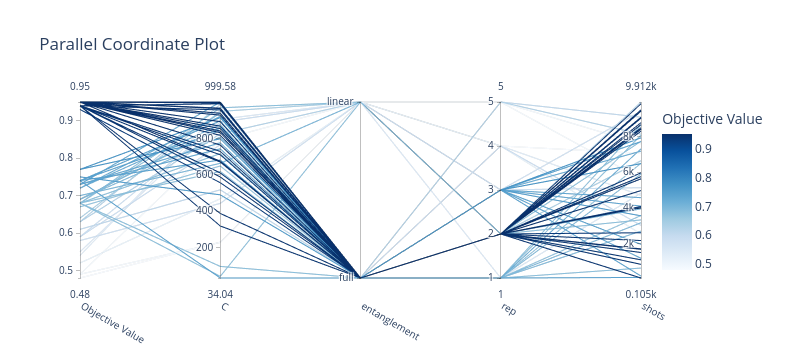

In [22]:
optuna.visualization.plot_parallel_coordinate(study, params=['rep', 'entanglement', "shots", "C"])


This  plot_param_importances() generates a bar plot to visualize the relative importances of different hyperparameters in influencing the optimization process during a hyperparameter search conducted using Optuna. In our case it shows that the number of repetitions is the dominating parameter. 

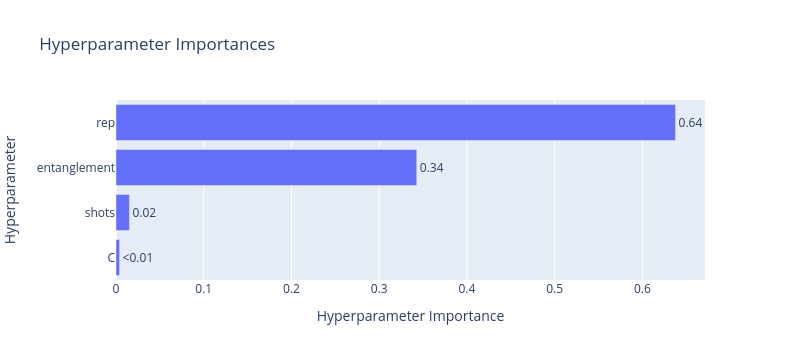

In [23]:
optuna.visualization.plot_param_importances(study)

Finally, the trials generated within our optimization study are converted to a dataframe and saved as a csv file.

In [55]:
history_csv = study.trials_dataframe()

In [56]:
history_csv.to_csv("hist.csv")